In [2]:
import tensorflow as tf
from object_detection.utils import dataset_util
import pandas as pd
import numpy as np
import os
import io
import matplotlib.pyplot as plt
from object_detection.dataset_tools import tf_record_creation_util
from sklearn.model_selection import train_test_split

In [3]:
IMAGE_PATH = './Data/real_pngs/'
TFRECORDS_PATH = './Data/tf_records/'

# using typical split of 70:20:10
SIZE_OF_VALIDATION_SET = 0.2
SIZE_OF_TEST_SET = 0.1

# 200px x 200px used by Hugh originally, expanding a bit as some features are cut off
CUTOUT = np.array([50, 350, 50, 350])
CUTOUT_NORMED = np.array([50, 350, 50, 350])/400

In [4]:
# Loading the data
DATA_PATH = './Data/'

file_path1 = DATA_PATH + 'combined_cat.pkl'
file_path2 = DATA_PATH + 'zoo2LocalIdMap.pkl'
file_path3 = DATA_PATH + 'metadata.pkl'

df_combined_cat = (pd
    .read_pickle(file_path1)
    #.reset_index() 
    #.explode('false_pos_prob_stats')
)

zooToLocal = pd.read_pickle(file_path2)
df_combined_cat["local_ids"] = zooToLocal.loc[df_combined_cat.index.get_level_values(0)].to_numpy()

df_combined_cat.reset_index(inplace=True)

df_zoo2LocalIdMap = (pd
    .read_pickle(file_path2)
    .to_frame()
    .reset_index()
    .rename(columns={'index': 'zoo_id', 0: 'id'})
    )

# creating work df
df_zoo2LocalIdMap['filename'] = df_zoo2LocalIdMap['id'].apply(str) + '.png'
df_zoo2LocalIdMap['file_exists'] = (DATA_PATH + 'real_pngs/' + df_zoo2LocalIdMap['filename']).apply(os.path.exists)
df_clumps = df_combined_cat[['local_ids', 'empty']].drop_duplicates(subset=['local_ids', 'empty'])

# read metadata from pickle file for the origin-field
metadata = (pd.read_pickle(file_path3))
df_metadata = pd.DataFrame.from_dict(metadata, orient='index')
df_table = pd.concat([df_metadata, df_metadata['ra, dec'].str.split(', ', expand=True)], axis=1)

df_table.columns = [
    'id', 'filename_stem', 'dr8objid', 'ra, dec', 'redshift', 'SDSS navigator',
    'origin', 'fwhm', 'fwhmNativePix', 'fwhmImagePix', 'arcsecPerSide', 'ra', 'dec'
]

df_table = df_table[
    ['id', 'dr8objid', 'ra', 'dec', 'fwhm', 'origin', 'redshift', 'fwhmImagePix',
    'arcsecPerSide', 'fwhmNativePix']
]

df_table['id'] = pd.to_numeric(df_table['id'])
df_table['dr8objid'] = pd.to_numeric(df_table['dr8objid'])
df_table['ra'] = pd.to_numeric(df_table['ra'])
df_table['dec'] = pd.to_numeric(df_table['dec'])
df_table['fwhm'] = pd.to_numeric(df_table['fwhm'])
df_table['redshift'] = pd.to_numeric(df_table['redshift'])
df_table['fwhmImagePix'] = pd.to_numeric(df_table['fwhmImagePix'])
df_table['arcsecPerSide'] = pd.to_numeric(df_table['arcsecPerSide'])
df_table['fwhmNativePix'] = pd.to_numeric(df_table['fwhmNativePix'])

# join metadata to final df and drop rows
df = (df_zoo2LocalIdMap
    .merge(df_clumps, how='inner', left_on='id', right_on='local_ids')
    .merge(df_table, how='inner', left_on='id', right_on='id')
)

# labels
df['label'] = np.select(
    [
        df['empty'], 
        ~df['empty'], 
    ], 
    [
        0,
        1,
    ], 
    default=0
)

df['label_text'] = np.select(
    [
        df['empty'], 
        ~df['empty'], 
    ], 
    [
        'w/o clumps',
        'clumpy',
    ], 
    default='w/o clumps'
)

In [10]:
# Save df to file
df.to_csv(DATA_PATH + 'clumps.csv', index=False)

In [5]:
df_combined_cat[df_combined_cat['local_ids'] == 310746845936]

,image_id,association,x1,x2,y1,y2,x1_normed,x2_normed,y1_normed,y2_normed,...,multiplicity,false_pos_prob_stats,false_pos_prob,inaccurate_prob,risk,empty,batch,finish_criterion,image_multiplicity,local_ids
41831,36740307,11,115.662088,136.570931,153.749190,174.658033,0.289155,0.341427,0.384373,0.436645,...,9,"[9.0, 0.2498501246931389, 0.20811973389196042,...",9.774794e-02,9.044029e-04,9.946834e-02,False,134,completion_assessor,20,310746845936
41832,36740307,15,165.954262,186.863106,214.137330,235.046174,0.414886,0.467158,0.535343,0.587615,...,19,"[19.0, 0.225721018271843, 0.16455703443010525,...",3.496220e-12,4.677982e-08,9.356314e-08,False,134,completion_assessor,20,310746845936
41833,36740307,23,212.929495,233.838339,105.432875,126.341719,0.532324,0.584596,0.263582,0.315854,...,6,"[6.0, 0.1344105016765531, 0.01274410348499205,...",1.204373e-01,3.532676e-03,1.270772e-01,False,134,completion_assessor,20,310746845936


In [6]:
df.head()

,zoo_id,id,filename,file_exists,local_ids,empty,dr8objid,ra,dec,fwhm,origin,redshift,fwhmImagePix,arcsecPerSide,fwhmNativePix,label,label_text
0,36718137,248728316855,248728316855.png,True,248728316855,False,1237661849856245807,176.95517,43.74820,1.320678,real,0.025232,5.128205,103.012894,3.335045,1,clumpy
1,36718138,366658689799,366658689799.png,True,366658689799,False,1237664092902326345,137.11852,28.91105,1.090659,real,0.021380,6.639190,65.710367,2.754189,1,clumpy
2,36718139,325803584733,325803584733.png,True,325803584733,False,1237661873490034916,223.50713,38.65756,1.007018,real,0.028443,5.002343,80.523714,2.542975,1,clumpy
3,36718140,661474437524,661474437524.png,True,661474437524,True,1237667107426402363,126.05962,17.33196,0.889575,real,0.037252,5.715921,62.252415,2.246401,0,w/o clumps
4,36718141,130224042401,130224042401.png,True,130224042401,True,1237651497367699565,117.14433,44.68828,1.153457,real,0.020354,4.357369,105.885647,2.912770,0,w/o clumps


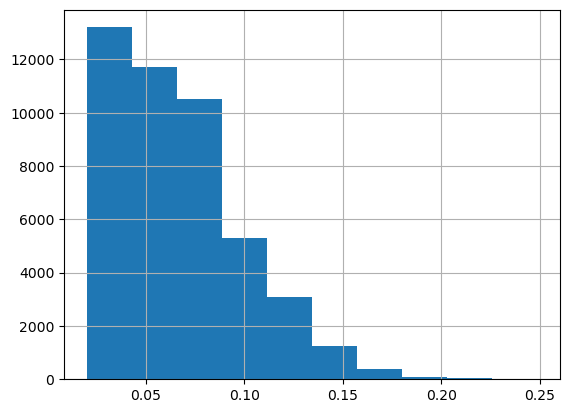

In [7]:
hist = df['redshift'].hist(bins=10)

In [91]:
df.head()

,id,filename,zoo_id,dr8objid,label,label_text
0,100011049412,100011049412.png,36746082,1237650762924621828,1,clumpy
1,100020597844,100020597844.png,36804253,1237662475303977209,1,clumpy
2,100025800792,100025800792.png,36739911,1237661972269564074,1,clumpy
3,100048800767,100048800767.png,36746620,1237657857145962628,1,clumpy
4,100056351243,100056351243.png,36798459,1237662195059785839,0,w/o clumps


In [5]:
# Randomly divide into train and validation sets using sklearn
train_df, hidden_df = train_test_split(df, test_size=SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET)
val_df, test_df = train_test_split(hidden_df, test_size=SIZE_OF_TEST_SET / (SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET))
# train_df, val_df = train_test_split(df, test_size=SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET, random_state=42)

In [6]:
print('Training subjects: {}'.format(len(train_df)))
print('Val subjects: {}'.format(len(val_df)))
print('Test subjects: {}'.format(len(test_df)))
print('Sum: {}, of {} in total.'.format(len(train_df)+len(val_df)+len(test_df), len(df)))
# print('Sum: {}, of {} in total.'.format(len(train_df)+len(val_df), len(df)))

Training subjects: 31950
Val subjects: 9128
Test subjects: 4565
Sum: 45643, of 45643 in total.


In [7]:
labels = list(df['label'].astype(int))
print('Labels: \n{}'.format(pd.value_counts(labels)))

Labels: 
0    25656
1    19987
dtype: int64


In [8]:
def create_tf_example(image_file_path, image_id, image_label, image_label_text):
    if not os.path.exists(image_file_path):
        print(f"WARNING! {image_file_path} not found!")
        return None

    height = CUTOUT[3] - CUTOUT[2] # Image height
    width = CUTOUT[1] - CUTOUT[0] # Image width
    encoded_image_data = tf.io.read_file(image_file_path) # Encoded image bytes
    image_tensor_uint8 = tf.image.decode_png(encoded_image_data)
    clipped_image_data = tf.image.encode_png(image_tensor_uint8[CUTOUT[0]:CUTOUT[1], CUTOUT[2]:CUTOUT[3]])
    encoded_image_data = clipped_image_data.numpy()
    image_format = b"PNG" # b'jpeg' or b'png'

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/source_id': dataset_util.int64_feature(image_id),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/label_text': dataset_util.bytes_feature('image_label_text'.encode('utf-8')),
        'image/label': dataset_util.int64_feature(image_label),
    }))
    return tf_example

In [11]:
shard_size = 3000
print(len(df) // shard_size + 1)

16


In [19]:
dfs = np.array_split(df, 16)
for index, df in enumerate(dfs):
    print('Index: {}, Size: {}'.format(index, len(df)))

Index: 0, Size: 2853
Index: 1, Size: 2853
Index: 2, Size: 2853
Index: 3, Size: 2853
Index: 4, Size: 2853
Index: 5, Size: 2853
Index: 6, Size: 2853
Index: 7, Size: 2853
Index: 8, Size: 2853
Index: 9, Size: 2853
Index: 10, Size: 2853
Index: 11, Size: 2852
Index: 12, Size: 2852
Index: 13, Size: 2852
Index: 14, Size: 2852
Index: 15, Size: 2852


In [9]:
def write_catalog_to_tfrecord_shards(df, tf_record_file_name, num_shards):
    tf_record_file_path = TFRECORDS_PATH + tf_record_file_name + '_{}.tfrecords'
    dfs = np.array_split(df, num_shards)

    for index, df in enumerate(dfs):
        tf_record_shardfile_path = tf_record_file_path.format(index)

        with tf.io.TFRecordWriter(tf_record_shardfile_path) as writer:
            missing = 0
            
            for index, row in df.iterrows():
                image_file_path = os.path.join(IMAGE_PATH, row['filename'])
                image_id = row['id']
                image_label = row['label']
                image_label_text = row['label_text']
                tf_example = create_tf_example(image_file_path, image_id, image_label, image_label_text)
                
                if tf_example is not None:
                    writer.write(tf_example.SerializeToString())
                else:
                    print("missing")
                    missing += 1

In [10]:
# create TF Records
# shard size of 1000 should lead to roughly 100MB files
shard_size = 3000
# write_catalog_to_tfrecord_shards(df, 'GZ2_ClumpScout', (len(df) // shard_size) + 1)
write_catalog_to_tfrecord_shards(train_df, 'GZ2_ClumpScout_train', (len(train_df) // shard_size) + 1)
write_catalog_to_tfrecord_shards(val_df, 'GZ2_ClumpScout_val', (len(val_df) // shard_size) + 1)
write_catalog_to_tfrecord_shards(test_df, 'GZ2_ClumpScout_test', (len(test_df) // shard_size) + 1)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-18 10:23:55.337744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-18 10:23:55.338033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
# create smaller set of TF Records for testing
write_catalog_to_tfrecord_shards(train_df.sample(frac=0.1), 'test_train', 1)
write_catalog_to_tfrecord_shards(val_df.sample(frac=0.1), 'test_val', 1)
write_catalog_to_tfrecord_shards(test_df.sample(frac=0.1), 'test_test', 1)

2022-12-17 08:11:45.302067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-17 08:11:45.302197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [14]:
import pathlib
test_set =  sorted(str(p) for p in pathlib.Path(TFRECORDS_PATH).glob('GZ2_ClumpScout_test*.tfrecords'))

In [15]:
print(test_set)

['Data/tf_records/GZ2_ClumpScout_test_0.tfrecords', 'Data/tf_records/GZ2_ClumpScout_test_1.tfrecords']


In [16]:
test_image_dataset = tf.data.TFRecordDataset(test_set)

# Create a dictionary describing the features.
test_image_feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/source_id': tf.io.FixedLenFeature([], tf.int64),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/label_text': tf.io.FixedLenFeature([], tf.string),
    'image/label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, test_image_feature_description)

parsed_image_dataset = test_image_dataset.map(_parse_image_function)

In [17]:
for data in parsed_image_dataset.take(1):
    print(data['image/source_id'])
    # print(data['image/label_text'])
    print(tf.io.decode_raw(data['image/label_text'], tf.int64))

tf.Tensor(328709103399, shape=(), dtype=int64)
tf.Tensor([7020090808294534505 8392569456096470370], shape=(2,), dtype=int64)


2022-12-18 10:33:57.098969: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


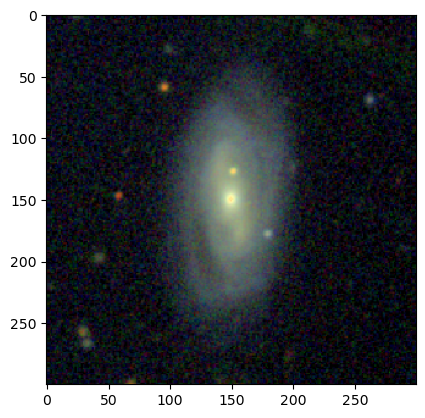

In [18]:
for image_features in parsed_image_dataset.take(1):
  image_raw = tf.image.decode_image(image_features['image/encoded']).numpy()
  plt.imshow(image_raw)